In [4]:
import pandas as pd
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import os
from skimage.morphology import skeletonize
from skimage.feature import corner_peaks
from scipy.ndimage import convolve, label, center_of_mass
from skimage.morphology import skeletonize
from collections import deque
from typing import List, Tuple, Dict
from scipy.ndimage import binary_hit_or_miss
from scipy.ndimage import distance_transform_edt, convolve, label, center_of_mass
from skimage.graph import route_through_array
import random
import seaborn as sns

In [ ]:
# read the image file 

input_image = cv2.imread("../g-5-2SMI/G-5-2_trab._Raw import  W0.00 L0.00_020.tiff")

In [5]:
 # Convert BGR to RGB for proper matplotlib display
rgb_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

In [6]:
h, w, _ = rgb_image.shape
scale = 8
method = cv2.INTER_LANCZOS4

# resize image 

resized  = cv2.resize(rgb_image, (w*scale,h*scale), interpolation=method)

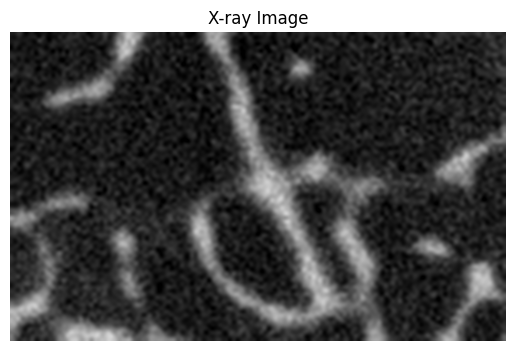

In [7]:
# Show the image
plt.imshow(resized)
plt.title("X-ray Image")
plt.axis('off')
plt.show()

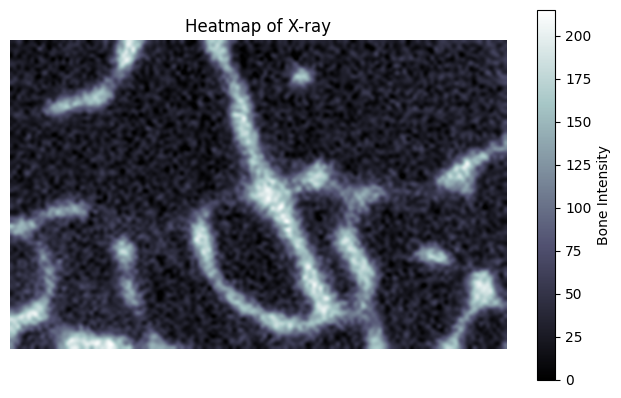

In [8]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

# Plot grayscale heatmap with colorbar using matplotlib
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(gray, cmap='bone')
plt.title("Heatmap of X-ray")
plt.axis("off")
plt.colorbar(heatmap, shrink=0.8, label="Bone Intensity")
plt.show()

In [9]:
print(gray)

[[ 29  29  29 ...  34  34  34]
 [ 29  29  29 ...  34  34  34]
 [ 29  29  28 ...  35  34  34]
 ...
 [115 115 115 ...  97  98  98]
 [115 115 114 ...  97  98  98]
 [115 115 114 ...  97  97  97]]


[[0.11372549 0.11372549 0.11372549 ... 0.13333333 0.13333333 0.13333333]
 [0.11372549 0.11372549 0.11372549 ... 0.13333333 0.13333333 0.13333333]
 [0.11372549 0.11372549 0.10980392 ... 0.1372549  0.13333333 0.13333333]
 ...
 [0.45098039 0.45098039 0.45098039 ... 0.38039216 0.38431373 0.38431373]
 [0.45098039 0.45098039 0.44705882 ... 0.38039216 0.38431373 0.38431373]
 [0.45098039 0.45098039 0.44705882 ... 0.38039216 0.38039216 0.38039216]]


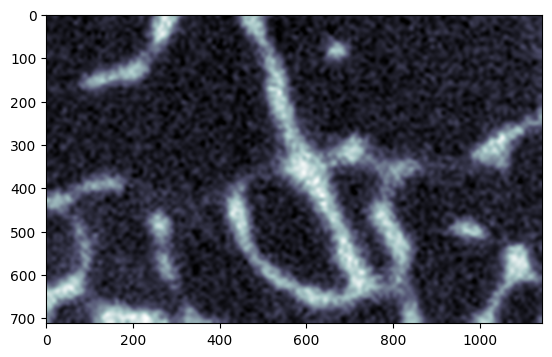

In [10]:
# convert into binary image 
gray = gray.astype(float)
for i in range(h*scale):
    for j in range(w*scale):
        gray[i][j] = gray[i][j] / 255

print(gray)

plt.imshow(gray, cmap='bone')

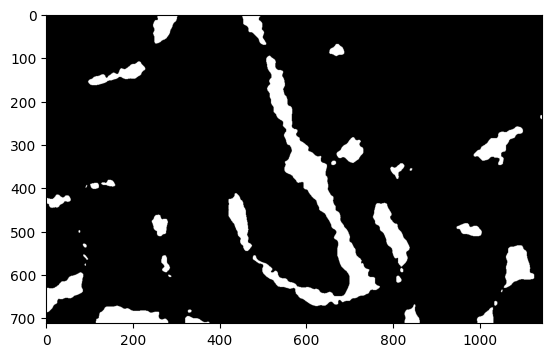

In [11]:
# convert into binary image 
gray = gray.astype(float)
for i in range(h*scale):
    for j in range(w*scale):
        if(gray[i][j] < 0.5): #The data loss percentage is controlled within the range of 0.37 to 0.58, resulting in a variation of no more than ±2.774%.
            gray[i][j] = 0
        else:
            gray[i][j] = 255

plt.imshow(gray, cmap='bone')

In [12]:
#Skeletonize the binary image
skel = skeletonize(gray).astype(np.uint8)

In [13]:
# Convert gray to uint8 before using cv2.cvtColor
gray_uint8 = gray.astype(np.uint8)
out = cv2.cvtColor(gray_uint8, cv2.COLOR_GRAY2BGR)

# Draw skeleton (in red)
ys, xs = np.where(skel)
out[ys, xs] = (0, 0, 255)

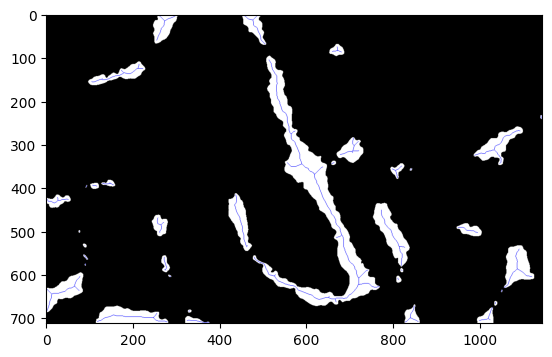

In [14]:
plt.imshow(out)

In [15]:
# Detect nodes (junction points)
nodes = corner_peaks(skel, min_distance=5, threshold_rel=0.1)

In [16]:
def neighbour_count(skel: np.ndarray) -> np.ndarray:
    kernel = np.ones((3, 3), np.uint8)
    return convolve(skel, kernel, mode="constant", cval=0) - skel

In [17]:
def find_nodes(skel: np.ndarray) -> List[Tuple[int, int]]:
    deg = neighbour_count(skel)
    node_mask = (skel == 1) & (deg >= 3)
    lbl, n_comp = label(node_mask)
    centroids = center_of_mass(node_mask, lbl, range(1, n_comp + 1))
    return [(int(round(r)), int(round(c))) for r, c in centroids]

In [18]:
def find_endpoints(skel: np.ndarray) -> List[Tuple[int, int]]:
    deg = neighbour_count(skel)
    return [tuple(p) for p in np.argwhere((skel == 1) & (deg == 1))]

In [19]:
nodes = find_nodes(skel)
endpoints = find_endpoints(skel)

In [20]:
# Draw nodes (green with red labels)
for node_id, (r, c) in enumerate(nodes, 1):
    cv2.circle(out, (c, r), 3, (0, 255, 0), -1)

# Draw endpoints (blue with "eX" labels)
for idx, (r, c) in enumerate(endpoints):
    cv2.circle(out, (c, r), 3, (255, 0, 0), -1)

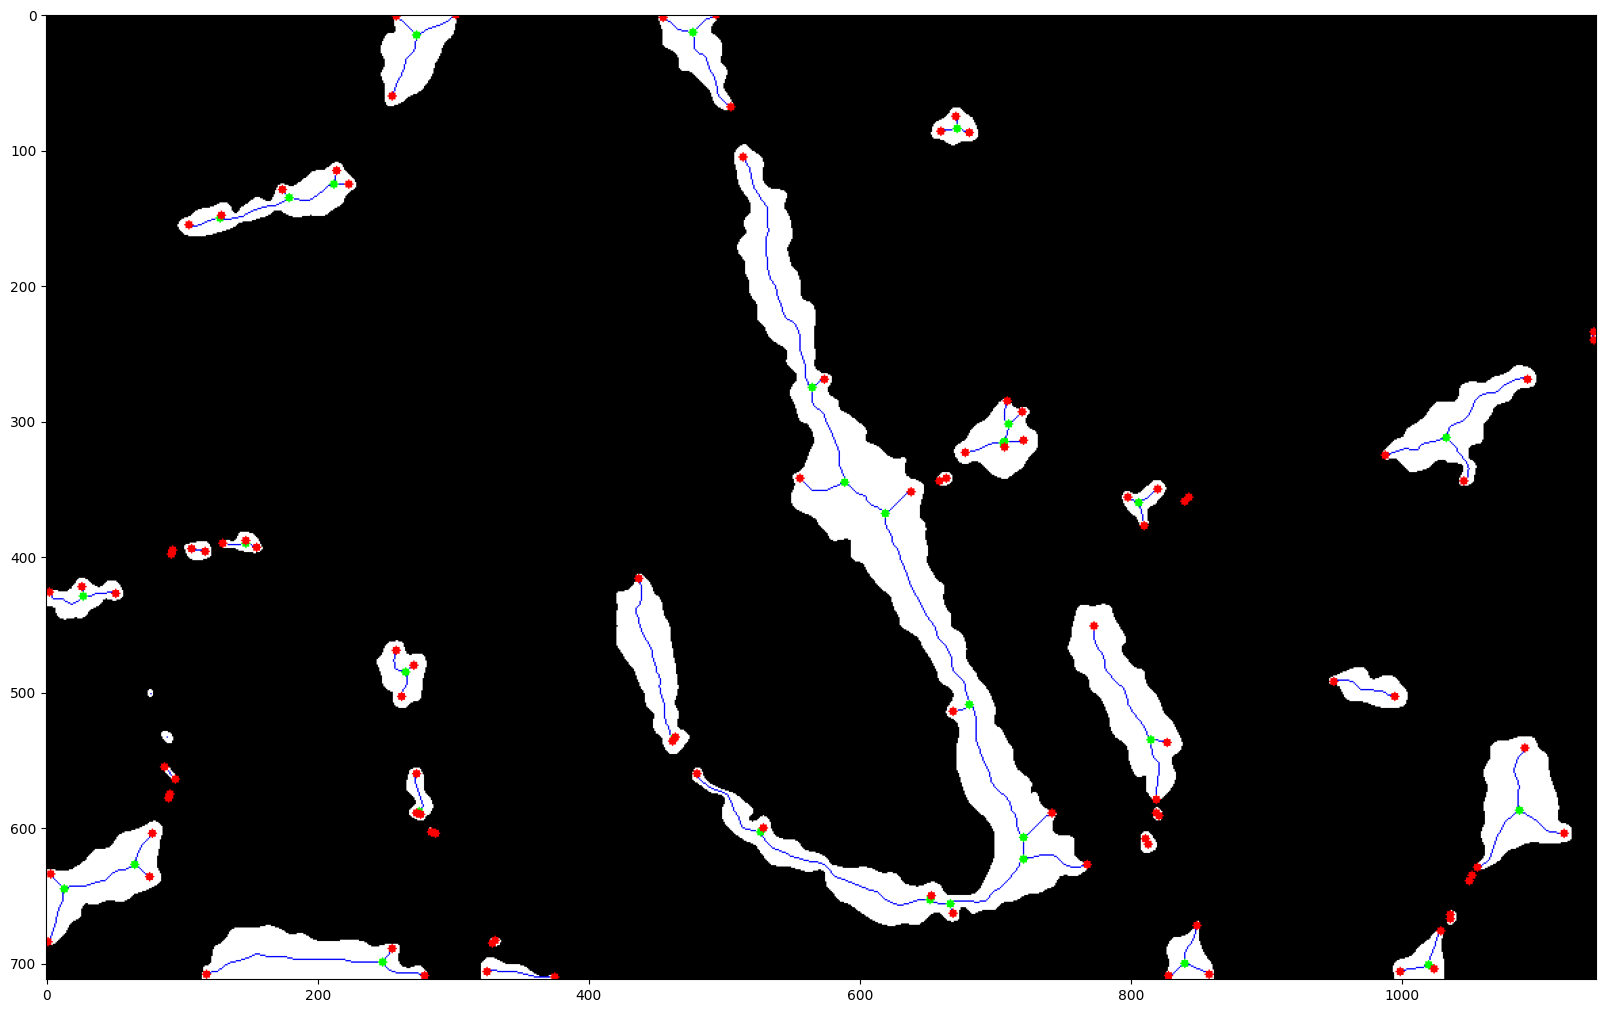

In [21]:
plt.figure(figsize=(20, 20))
plt.imshow(out)

In [4]:
node_data = pd.read_csv("../skeletonise_image.csv")
# Show data sorted by Node1_ID
node_data.sort_values("Node1_ID")

,Node1_ID,Coord1,Node2_ID,Coord2,Distance,End_point,E_Coord,E_Distance
11,1,"(13,477)",NaN,NaN,NaN,e1,"(0,494)",21.40093
12,2,"(15,273)",NaN,NaN,NaN,e0,"(0,302)",32.64966
13,3,"(84,672)",NaN,NaN,NaN,e6,"(75,671)",9.05539
0,4,"(125,212)",5.0,"(135,179)",34.48188,e10,"(115,214)",10.19804
1,5,"(135,179)",6.0,"(150,128)",53.16014,e12,"(129,174)",7.81025
14,6,"(150,128)",NaN,NaN,NaN,e13,"(148,129)",2.23607
2,7,"(275,565)",12.0,"(345,589)",74.00000,e17,"(269,574)",10.81665
3,8,"(302,710)",10.0,"(315,707)",13.34166,e19,"(285,709)",17.02939
15,9,"(312,1033)",NaN,NaN,NaN,e15,"(234,1142)",134.03358
4,10,"(315,707)",11.0,"(316,706)",1.41421,e21,"(314,721)",14.03567


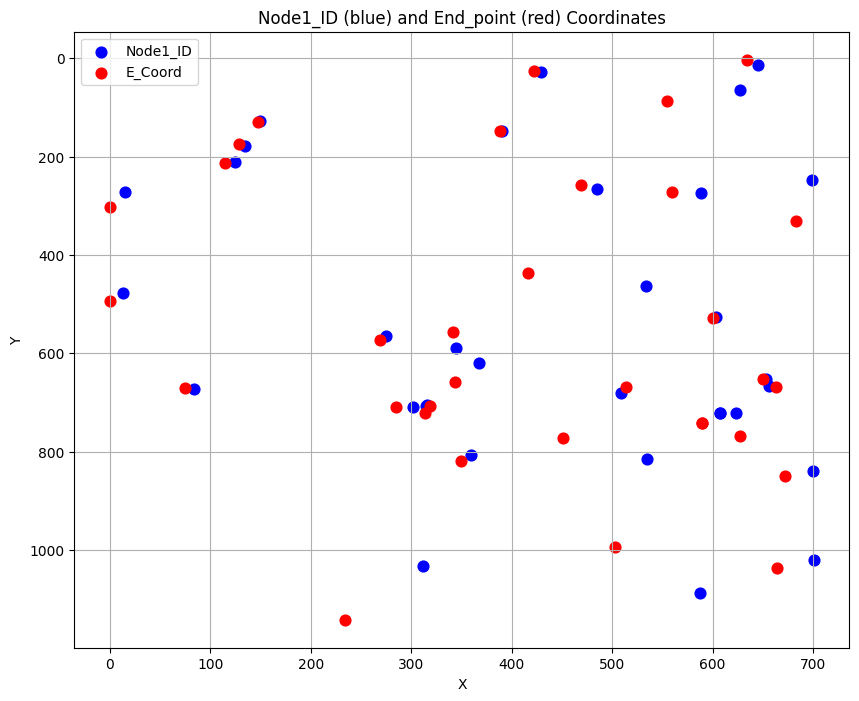

In [6]:
# Extract x, y coordinates from Coord1 and E_Coord columns
node_xy = node_data["Coord1"].apply(lambda s: eval(s))
end_xy = node_data["E_Coord"].apply(lambda s: eval(s))

node_x, node_y = zip(*node_xy)
end_x, end_y = zip(*end_xy)

plt.figure(figsize=(10, 8))
plt.scatter(node_x, node_y, color='blue', label='Node1_ID', s=60)
plt.scatter(end_x, end_y, color='red', label='E_Coord', s=60)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Node1_ID (blue) and End_point (red) Coordinates")
plt.legend()
plt.gca().invert_yaxis()  # Optional: match image coordinate system
plt.grid(True)
plt.show()

In [22]:
def geodesic_radius(binary_img, node):
    """Calculate the distance from node to the nearest background pixel"""
    # Invert image: white=1, black=0
    mask = (binary_img > 0).astype(np.uint8)
    # Compute distance transform from black pixels (boundary)
    dist = distance_transform_edt(mask)
    # The value at the node is the Euclidean distance to the nearest black pixel
    y, x = node
    radius = dist[y, x]
    return radius

In [23]:
# Process nodes - use same indexing as skeleton.py (1-based)
for idx, (r, c) in enumerate(nodes):
    # Convert back to 255-scale binary for radius calculation
    binary_255 = (gray * 255).astype(np.uint8)
    radius = geodesic_radius(binary_255, (r, c))
    
    # Draw circle around node
    cv2.circle(out, (c, r), int(radius), (255, 0, 255), 2)  # pink circle

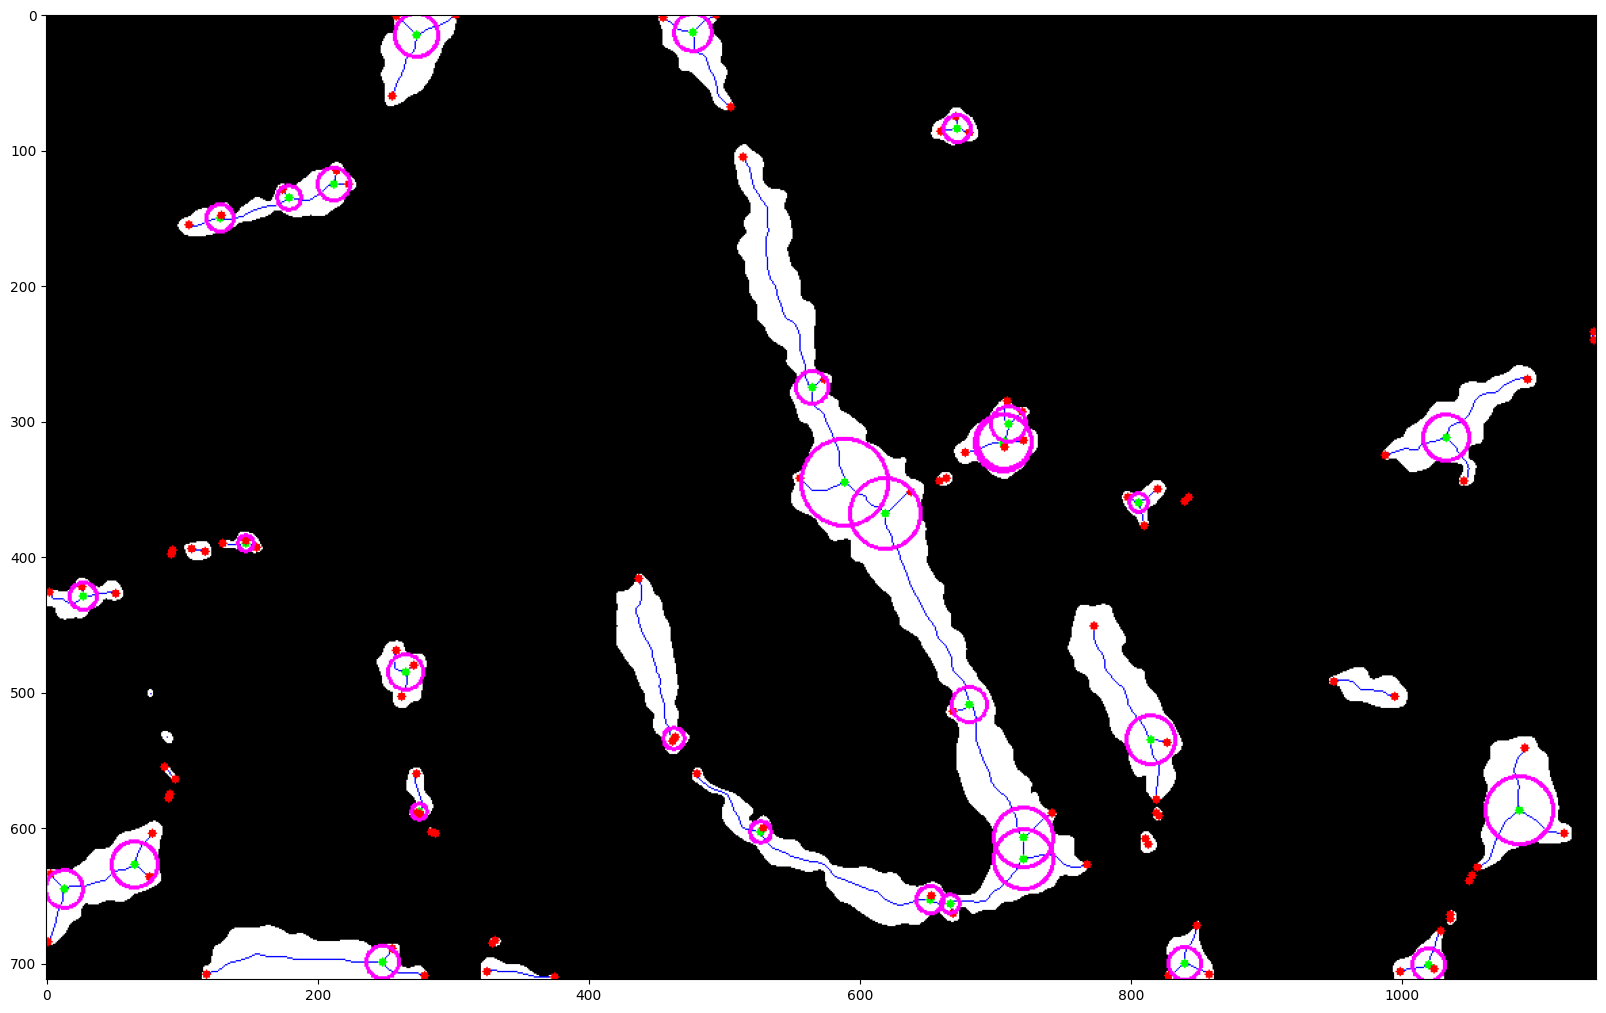

In [24]:
plt.figure(figsize=(20, 20))
plt.imshow(out)

In [7]:
data = pd.read_csv("../circle_image.csv")
data.head(5)

,node_id,x,y,radius
0,1,477,13,14.000000
1,2,273,15,16.278821
2,3,672,84,10.440307
3,4,212,125,12.727922
4,5,179,135,9.000000


In [8]:
data["radius"].describe()

count    32.000000
mean     14.457434
std       6.353671
min       6.324555
25%      10.379740
50%      12.883163
75%      17.442425
max      32.310989
Name: radius, dtype: float64

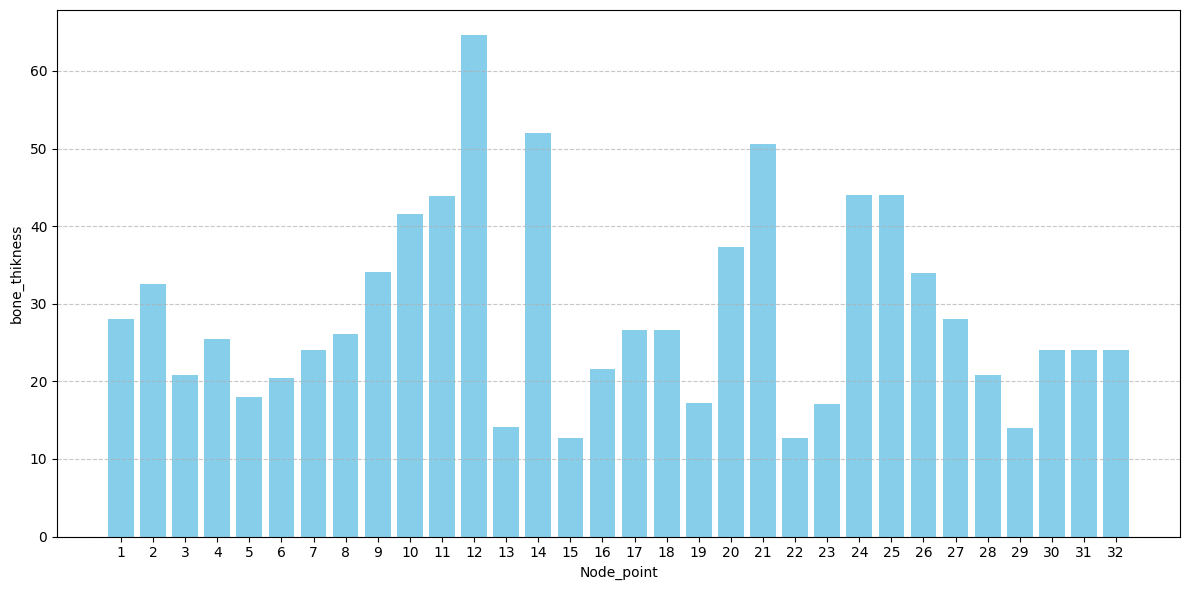

In [9]:
# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(data["node_id"], data["radius"]*2, color='skyblue')

# Add labels and title
plt.xlabel("Node_point")
plt.ylabel("bone_thikness")
# plt.title("Bone thikness at Node point")
plt.xticks(data["node_id"])  
    
# Show grid for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [28]:
def euclidean_dist(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

In [29]:
def midpoint(p1, p2):
    return ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)

In [30]:
def angle_between(p1, p2):
    dy = p2[0] - p1[0]
    dx = p2[1] - p1[1]
    return np.degrees(np.arctan2(dy, dx)) % 180

In [31]:
def fit_chain_ellipses(region_nodes, region_ends, out_img,ellipse_data, id_start):
    count = id_start
    visited = set()

    connections = {}
    all_points = region_nodes + region_ends

    for p1 in all_points:
        if p1 in visited:
            continue
        # Find nearest unvisited neighbor within same region
        candidates = [p2 for p2 in all_points if p2 != p1 and (p1, p2) not in visited and (p2, p1) not in visited]
        if not candidates:
            continue

        p2 = min(candidates, key=lambda x: euclidean_dist(p1, x))

        mid = midpoint(p1, p2)
        major = euclidean_dist(p1, p2) / 2
        minor = max(3, major * 0.5)
        angle = angle_between(p1, p2)

        ellipse_data.append({
            'pair_id': count,
            'x': mid[1],
            'y': mid[0],
            'semi_major': major,
            'semi_minor': minor,
            'angle': angle
        })

        cv2.ellipse(out_img, (mid[1], mid[0]), (int(major), int(minor)),
                    angle, 0, 360, (0, 255, 0), 2)

        visited.add(p1)
        visited.add(p2)
        count += 1

    return count



In [32]:
out_img = cv2.cvtColor(gray.astype(np.uint8), cv2.COLOR_GRAY2BGR)
ys, xs = np.where(skel)
out_img[ys, xs] = (0, 0, 255)

labeled, num = label(gray)
ellipse_data = []
count = 1

for region in range(1, num + 1):
    mask = labeled == region
    region_nodes = [p for p in nodes if mask[p]]
    region_ends = [p for p in endpoints if mask[p]]

    # Draw ellipses between endpoint-node and node-node
    count = fit_chain_ellipses(region_nodes, region_ends, out_img, ellipse_data, count)

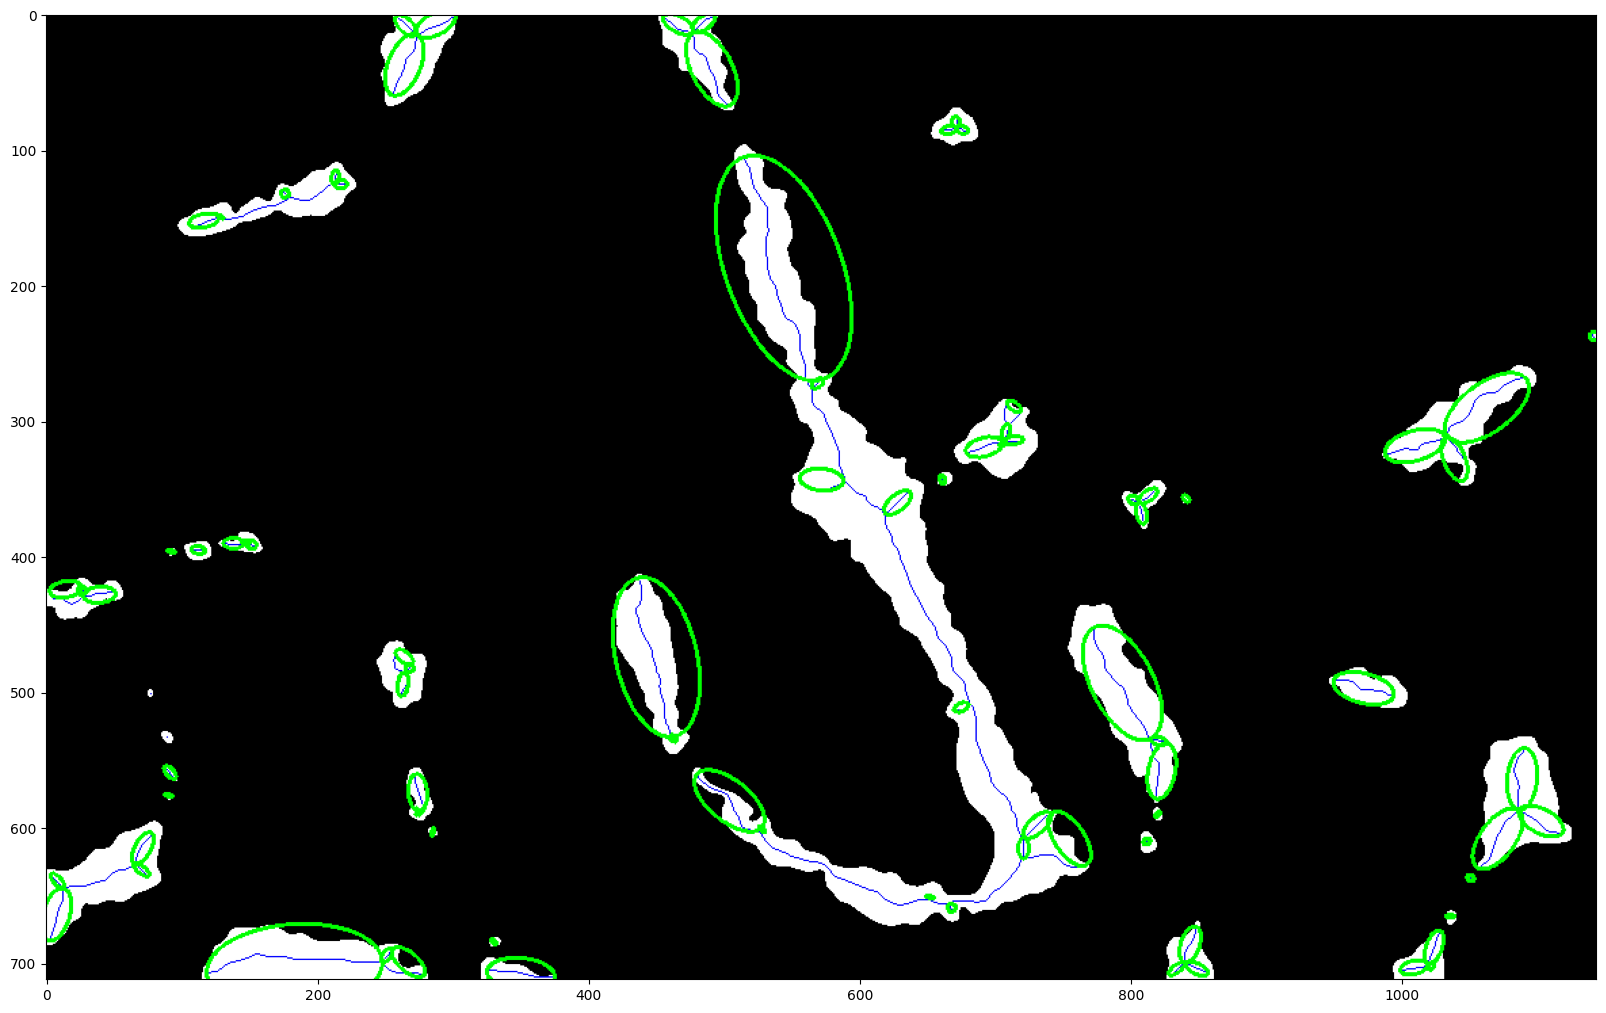

In [33]:
plt.figure(figsize=(20, 20))
plt.imshow(out_img)

In [34]:
total_possible_pairs = 0

for region in range(1, num + 1):
    mask = labeled == region
    region_nodes = [p for p in nodes if mask[p]]
    region_ends = [p for p in endpoints if mask[p]]
    region_all = region_nodes + region_ends

    # Count unique node-node and endpoint-node pairs
    unique_pairs = set()

    # Node-node pairs
    for i in range(len(region_nodes)):
        for j in range(i + 1, len(region_nodes)):
            unique_pairs.add(tuple(sorted((region_nodes[i], region_nodes[j]))))

    # Endpoint-node pairs (closest only)
    for ept in region_ends:
        if not region_nodes:
            continue
        closest_node = min(region_nodes, key=lambda n: euclidean_dist(ept, n))
        unique_pairs.add(tuple(sorted((ept, closest_node))))

    total_possible_pairs += len(unique_pairs)

total_drawn_ellipses = len(ellipse_data)

error_percentage = 100 * (total_possible_pairs - total_drawn_ellipses) / total_possible_pairs if total_possible_pairs > 0 else 0

print(f"Total possible ellipses: {total_possible_pairs}")
print(f"Total drawn ellipses   : {total_drawn_ellipses}")
print(f"Error percentage        : {error_percentage:.2f}%")

Total possible ellipses: 113
Total drawn ellipses   : 87
Error percentage        : 23.01%


In [35]:
ellipse_data = pd.read_csv("../eclipse_image.csv")
ellipse_data

,pair_id,x,y,semi_major,semi_minor,angle
0,1,265,8,10.259142,5.129571,43.025066
1,2,287,7,16.324828,8.162414,152.650124
2,3,264,37,24.233242,12.116621,111.801409
3,4,485,6,10.700467,5.350234,142.594643
4,5,466,7,12.298374,6.149187,26.565051
...,...,...,...,...,...,...
82,83,1022,702,2.500000,3.000000,36.869898
83,84,1024,688,13.285330,6.642665,109.798876
84,85,1009,703,10.793517,5.396758,166.607502
85,86,330,684,1.414214,3.000000,135.000000


In [36]:
ellipse_data["semi_minor"].describe()

count    87.000000
mean      6.710762
std       6.853970
min       3.000000
25%       3.000000
50%       3.716517
75%       7.284078
max      43.657760
Name: semi_minor, dtype: float64

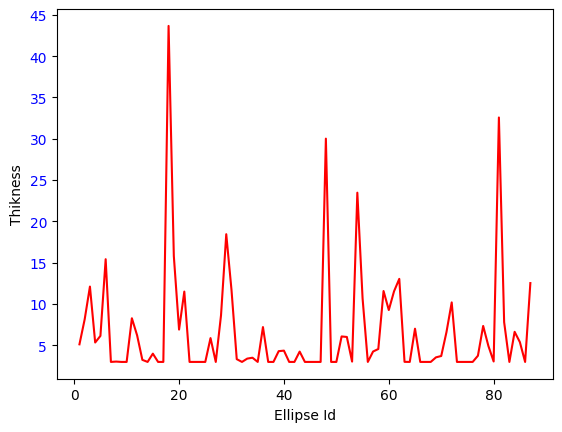

In [37]:
plt.xlabel("Ellipse Id")
plt.ylabel("Thikness")
plt.plot(ellipse_data["pair_id"],ellipse_data["semi_minor"], color="red",label="data base on average bone width")
plt.tick_params(axis='y', labelcolor="blue")

In [38]:
def generate_unique_color(existing_colors):
    while True:
        color = tuple(random.randint(50, 255) for _ in range(3))
        if color not in existing_colors and color not in [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255)]:  # Avoid red, green, blue, yellow
            return color


In [39]:
def connect_nodes_with_geodesic_lines(image, skeleton, nodes, color=(0, 255, 255)):
    skeleton = skeleton.astype(np.uint8)
    cost_map = 1.0 - skeleton  # low cost where skeleton is present

    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            start = tuple(nodes[i])
            end = tuple(nodes[j])

            # Use geodesic route through the skeleton
            try:
                path, cost = route_through_array(cost_map, start, end, fully_connected=True)
                path = np.array(path)
                if len(path) < 2 or cost > 1.5 * np.linalg.norm(np.array(start) - np.array(end)):
                    continue  # Skip very long or invalid connections

                # Draw the path in yellow
                for k in range(len(path) - 1):
                    pt1 = (path[k][1], path[k][0])
                    pt2 = (path[k + 1][1], path[k + 1][0])
                    cv2.line(image, pt1, pt2, color, 1)
            except:
                continue


In [40]:
def detect_nodes(skel_img):
    coords = corner_peaks(skel_img.astype(np.uint8), min_distance=5, threshold_rel=0.1)
    return coords

In [41]:
def geodesic_radius(binary_img, node):
    mask = (binary_img > 0).astype(np.uint8)
    dist = distance_transform_edt(mask)
    y, x = node
    return dist[y, x]

In [42]:
def all_circle(img_input):
    # Ensure the image is in uint8 format
    if img_input.dtype != np.uint8:
        img_input = (img_input * 255).astype(np.uint8) if img_input.max() <= 1.0 else img_input.astype(np.uint8)

    # Binarize image
    _, binary = cv2.threshold(img_input, 127, 255, cv2.THRESH_BINARY)

    # Label connected components
    labeled, num_shapes = label(binary)

    # Convert to BGR for visualization
    final_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    shape_data = []
    node_data = []
    existing_colors = set()
    node_id_counter = 0

    for shape_id in range(1, num_shapes + 1):
        mask = (labeled == shape_id).astype(np.uint8) * 255
        skel = skeletonize(mask // 255)

        nodes = detect_nodes(skel)
        color = generate_unique_color(existing_colors)
        existing_colors.add(color)

        shape_length = np.count_nonzero(skel)

        sorted_nodes = sorted(nodes, key=lambda p: (p[0], p[1]))  # y, x order

        for idx, (y, x) in enumerate(sorted_nodes):
            radius = geodesic_radius(mask, (y, x))
            node_data.append({
                'node_id': node_id_counter,
                'shape_id': shape_id,
                'x': x,
                'y': y,
                'radius': radius
            })

            # Draw radius circle
            cv2.circle(final_img, (x, y), int(radius), color, 1)
            # Mark center
            cv2.circle(final_img, (x, y), 2, (0, 255, 0), -1)
            node_id_counter += 1

        # Draw geodesic lines between nodes
        connect_nodes_with_geodesic_lines(final_img, skel, sorted_nodes, color=(255, 0, 0))

        # Mark shape ID at centroid
        ys, xs = np.nonzero(mask)
        if len(xs) > 0 and len(ys) > 0:
            cx = int(np.mean(xs))
            cy = int(np.mean(ys))
            cv2.putText(final_img, f'S{shape_id}', (cx - 10, cy), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 255), 1, cv2.LINE_AA)

        shape_data.append({'shape_id': shape_id, 'num_nodes': len(nodes), 'skeleton_length': shape_length})

    # Show output image
    plt.figure(figsize=(20, 20))
    plt.imshow(final_img)
    plt.axis('off')
    plt.title('Geodesic Radius Circles & Shape Labels')
    plt.show()

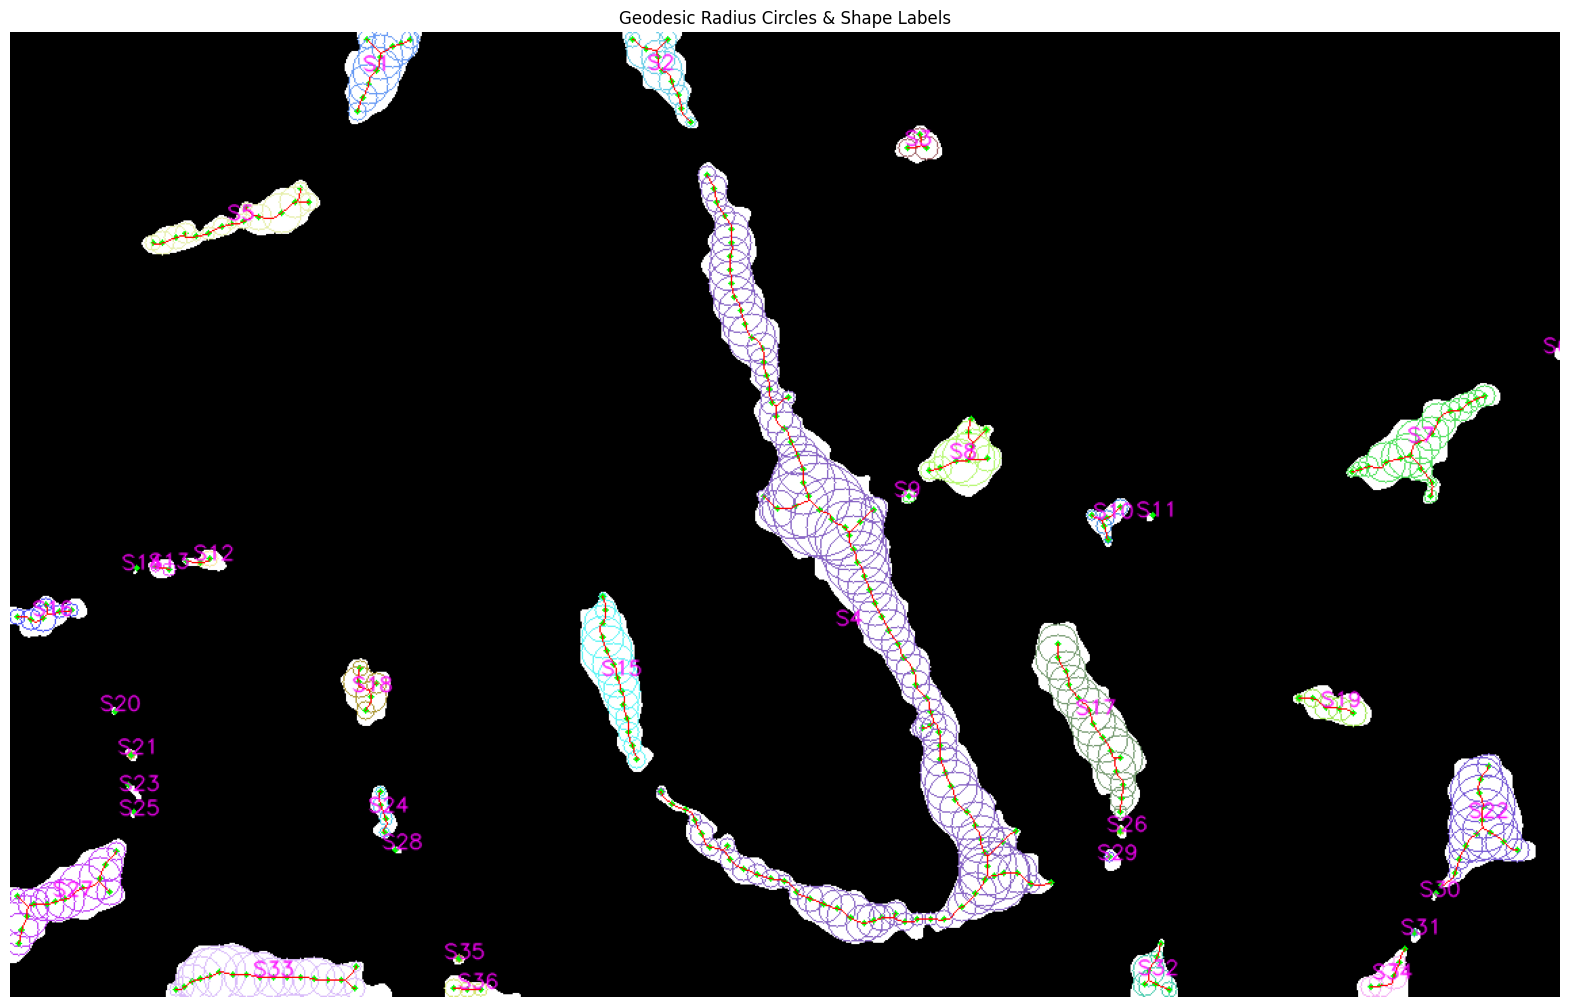

In [43]:
all_circle(gray)

In [5]:
lenth_data = pd.read_csv("../all_circle_shapes.csv")
lenth_data.head(5)

,shape_id,num_nodes,skeleton_length
0,1,9,90
1,2,9,98
2,3,3,31
3,4,96,956
4,5,15,137


In [6]:
lenth_data["skeleton_length"].describe()

count     36.000000
mean      76.027778
std      159.828566
min        1.000000
25%        4.750000
50%       36.500000
75%       92.000000
max      956.000000
Name: skeleton_length, dtype: float64

In [7]:
total_length_of_bone = sum(lenth_data["skeleton_length"])
total_length_of_bone

2737

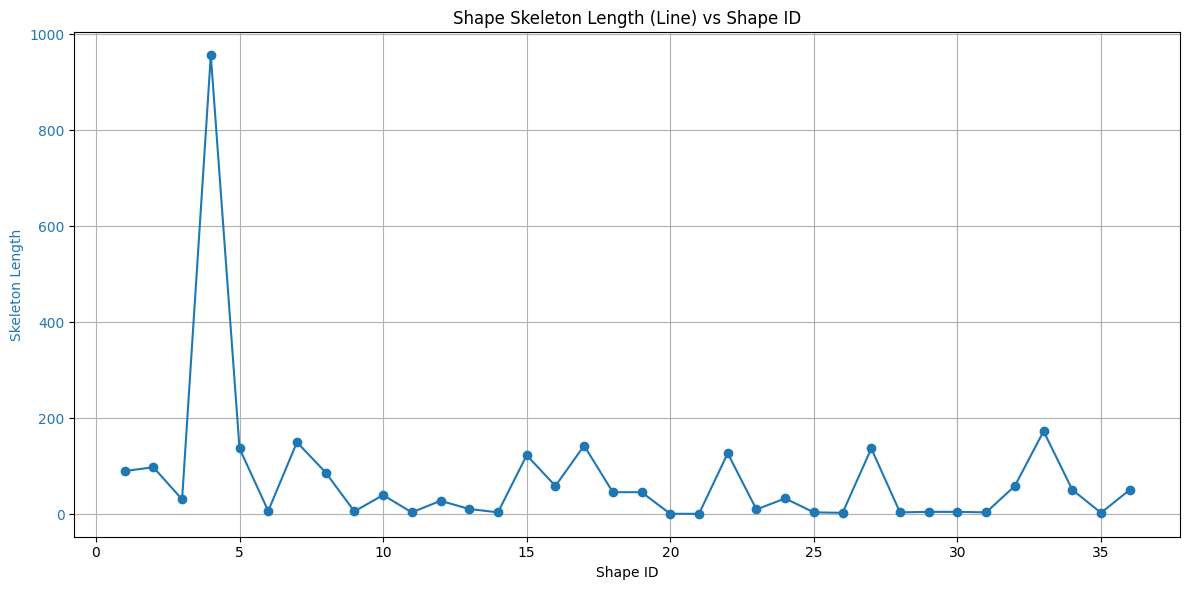

In [ ]:
# Set up figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis for line plot (skeleton length)
color_line = 'tab:blue'
ax1.set_xlabel('Shape ID')
ax1.set_ylabel('Skeleton Length', color=color_line)
ax1.plot(lenth_data['shape_id'], lenth_data['skeleton_length'], color=color_line, marker='o', label='Skeleton Length')
ax1.tick_params(axis='y', labelcolor=color_line)

# Second axis for bar plot (number of nodes)
ax2 = ax1.twinx()
color_bar = 'tab:orange'
ax2.set_ylabel('Number of Nodes', color=color_bar)
ax2.bar(lenth_data['shape_id'], lenth_data['num_nodes'], alpha=0.6, color=color_bar, label='Number of Nodes')
ax2.tick_params(axis='y', labelcolor=color_bar)

# Titles and layout
plt.title('Shape Skeleton Length (Line) and Node Count (Bar) vs Shape ID')
fig.tight_layout()
plt.grid(True)
plt.show()

<Axes: >

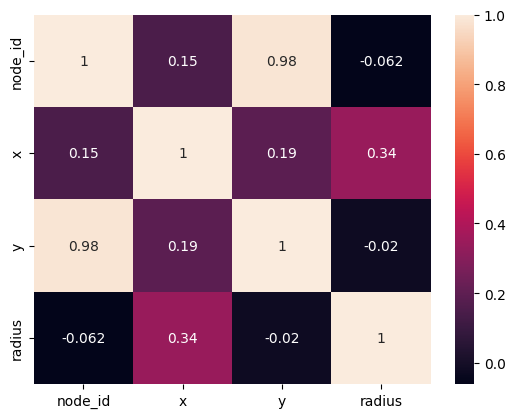

In [48]:
sns.heatmap(data.corr(),annot=True)

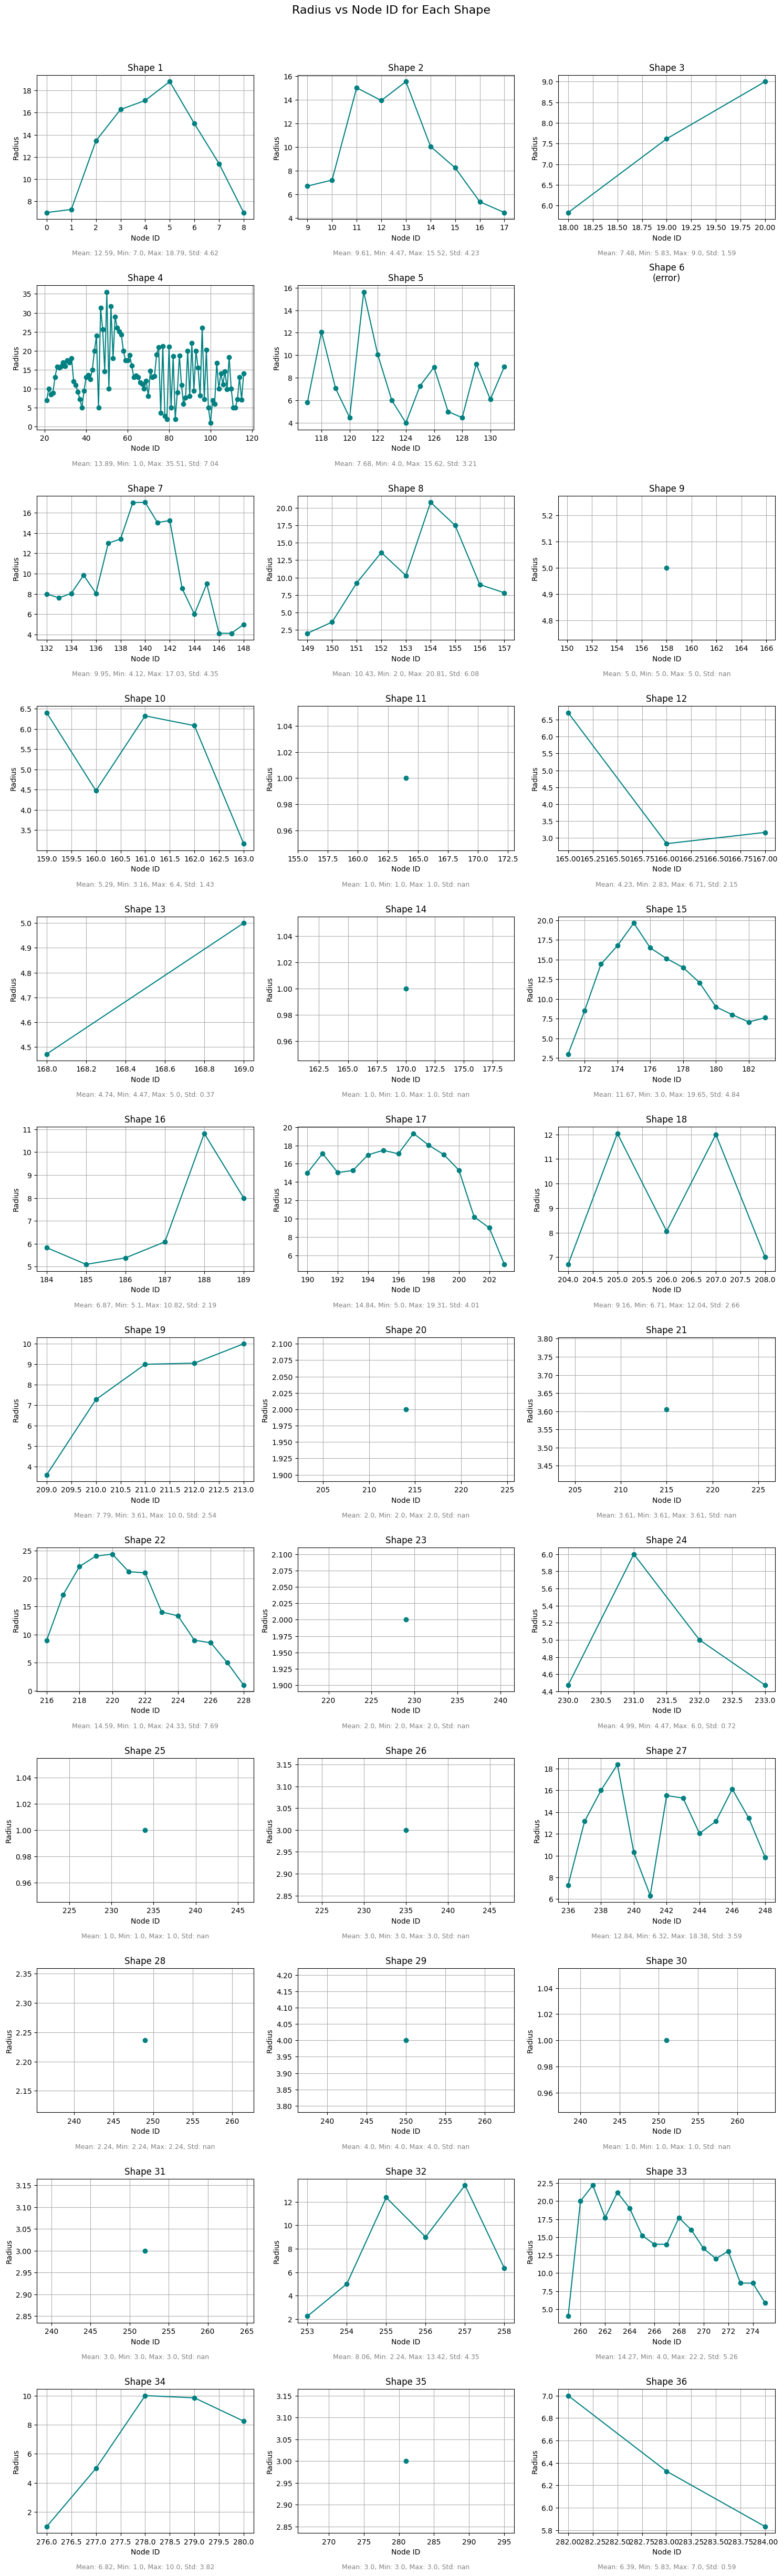

In [58]:

import os
import math

# Path to folder containing shape-specific node CSVs
folder_path = "../shape/"

if not os.path.exists(folder_path):
    print(f"Folder does not exist: {folder_path}")
else:
    node_csv_files = sorted(
        [f for f in os.listdir(folder_path)
         if f.startswith("node_circle_shape_") and f.endswith("_nodes.csv")],
        key=lambda name: int(name.split("_")[3])  # Extract shape_id from filename
    )

    num_shapes = len(node_csv_files)
    if num_shapes == 0:
        print("No shape node CSV files found in the folder.")
    else:
        cols = 3  
        rows = math.ceil(num_shapes / cols)

        # Create subplots
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
        axes = axes.flatten()  

        # Plot each shape in its subplot
        for i, file in enumerate(node_csv_files):
            shape_id = int(file.split("_")[3])
            file_path = os.path.join(folder_path, file)
            # Check if file is empty before reading
            if os.path.getsize(file_path) == 0:
                axes[i].set_title(f"Shape {shape_id}\n(empty file)")
                axes[i].axis("off")
                continue
            try:
                df = pd.read_csv(file_path)
                if df.empty or "node_id" not in df or "radius" not in df:
                    axes[i].set_title(f"Shape {shape_id}\n(no data)")
                    axes[i].axis("off")
                    continue

                df = df.sort_values("node_id")
                ax = axes[i]
                ax.plot(df["node_id"], df["radius"], marker='o', linestyle='-', color='teal')
                ax.set_title(f"Shape {shape_id}")
                ax.set_xlabel("Node ID")
                ax.set_ylabel("Radius")
                ax.grid(True)

                # Format the statistical summary as a note
                stats = df["radius"].describe().round(2)
                note = f"Mean: {stats['mean']}, Min: {stats['min']}, Max: {stats['max']}, Std: {stats['std']}"

                # Add the note below the plot
                ax.text(0.5, -0.25, note,
                        transform=ax.transAxes, ha='center', fontsize=9, color='gray')

            except Exception as e:
                axes[i].set_title(f"Shape {shape_id}\n(error)")
                axes[i].axis("off")
                continue

        # Hide unused subplots
        for j in range(len(node_csv_files), len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.suptitle("Radius vs Node ID for Each Shape", fontsize=16, y=1.02)
        plt.show()

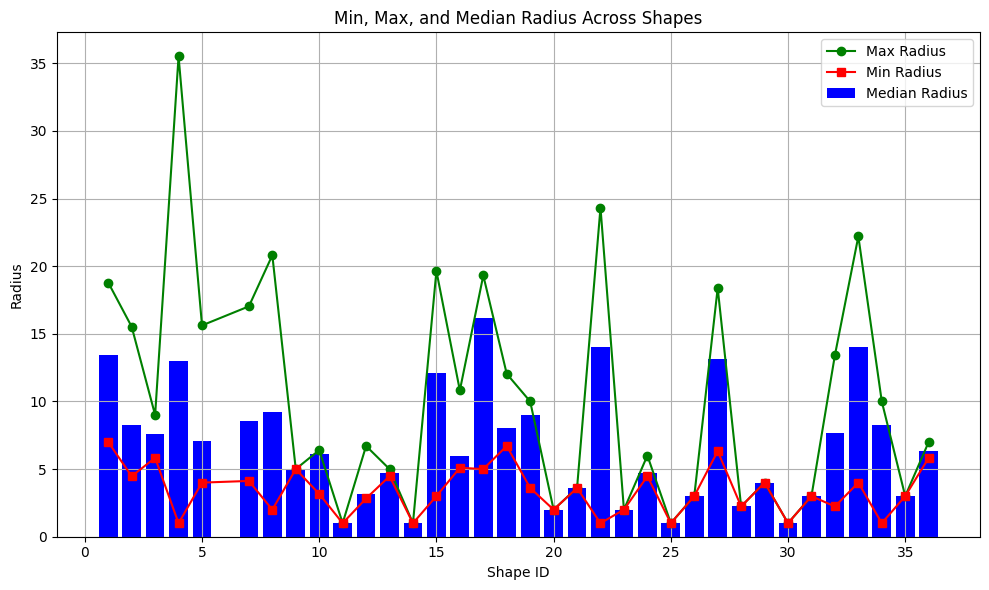

In [59]:
# Collect summary statistics from all shapes
shape_ids = []
min_vals = []
max_vals = []
median_vals = []

for file in node_csv_files:
    shape_id = int(file.split("_")[3])
    file_path = os.path.join(folder_path, file)

    if os.path.getsize(file_path) == 0:
        continue
    try:
        df = pd.read_csv(file_path)
        if df.empty or "radius" not in df:
            continue

        shape_ids.append(shape_id)
        min_vals.append(df["radius"].min())
        max_vals.append(df["radius"].max())
        median_vals.append(df["radius"].median())

    except:
        continue

# Sort values by shape_id to ensure consistent plotting
sorted_data = sorted(zip(shape_ids, min_vals, max_vals, median_vals), key=lambda x: x[0])

if sorted_data:
    shape_ids, min_vals, max_vals, median_vals = zip(*sorted_data)

    # Plot min, max, and median in the same line graph
    plt.figure(figsize=(10, 6))
    plt.plot(shape_ids, max_vals, color='green', marker='o', label='Max Radius')
    plt.plot(shape_ids, min_vals, color='red', marker='s', label='Min Radius')
    plt.bar(shape_ids, median_vals, color='blue', label='Median Radius')

    plt.xlabel("Shape ID")
    plt.ylabel("Radius")
    plt.title("Min, Max, and Median Radius Across Shapes")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No shape node CSV files found or no valid data to plot.")
